In [1]:
from concurrent.futures import ThreadPoolExecutor
import requests
import os
import glob
import re
from datetime import date

from Parsers.parsers import TURBD, FLORT

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse

### Parse raw recovered host data

In [40]:
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
def download_file(url, savepath=savepath):
    response = requests.get(url)
    if response.status_code == 200:
        filename = response.url.split("/")[-1]
    else:
        filename = url.split("/")[-1]
    with open(savepath+"/"+filename, mode="wb") as file:
        file.write(response.content)
    print(f"Downloaded file {filename}")

In [2]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd"
response = requests.get(url, stream=True)
response.url

'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd/'

In [3]:
response.content

b'<HTML>\n<HEAD>\n<SCRIPT>\nfunction help() {\n        window.open(\'http://oceanobservatories.org/data/raw-data/\',\'HELP\',\'height=1024,width=1280,menubar=no,scrollbars=yes,status=no,toolbar=no,left=100,top=100\');\n}\n</SCRIPT>\n<link rel="stylesheet" type="text/css" href="/style.css"\n</HEAD>\n<BODY>\n<CENTER><IMG SRC="/header.jpg" width="100%" height="auto"><BR><BR><A HREF="javascript:help();">Documentation</A><BR><BR></CENTER>\n<pre><img src="/icons/blank.gif" alt="Icon "> <a href="?C=N;O=D">Name</a>                                  <a href="?C=M;O=A">Last modified</a>      <a href="?C=S;O=A">Size</a>  <a href="?C=D;O=A">Description</a><hr><img src="/folder-home.png" alt="[PARENTDIR]"> <a href="/files/AS03CPSM/R00001/cg_data/dcl16/">Parent Directory</a>                                           -   \n<img src="/icons/text.gif" alt="[TXT]"> <a href="20221214.turbd.log">20221214.turbd.log</a>                    2022-12-14 23:55  1.1K  \n<img src="/icons/text.gif" alt="[TXT]"> <a h

In [6]:
os.makedirs("data/ast3_turbidity_data", exist_ok=True)
with open("data/ast3_turbidity_data/{filename}".format(filename=response.url.split('/')[-1]), mode="wb") as file:
    file.write(response.content)

In [2]:
files = glob.glob("data/ast3_turbidity_data/*.turbd.log")
files

['data/ast3_turbidity_data/20230109.turbd.log']

In [8]:
turbd = TURBD()
turbd.load_turbd(files)
data = turbd.DATA

Parsing 20230109.turbd.log


In [9]:
data

,LGR_TIMESTAMP,TIMESTAMP,TURBIDITY
0,2023-01-09 00:00:05.674,2023-01-09 00:00:03.500,6.1616
1,2023-01-09 00:00:06.175,2023-01-09 00:00:04.000,6.1662
2,2023-01-09 00:00:06.674,2023-01-09 00:00:04.500,6.1648
3,2023-01-09 00:00:07.174,2023-01-09 00:00:05.000,6.1640
4,2023-01-09 00:00:07.675,2023-01-09 00:00:05.500,6.1633
...,...,...,...
5664,2023-01-09 23:31:02.230,2023-01-09 23:31:00.000,6.2734
5665,2023-01-09 23:31:02.733,2023-01-09 23:31:00.500,6.2758
5666,2023-01-09 23:31:03.231,2023-01-09 23:31:01.000,6.2758
5667,2023-01-09 23:31:03.730,2023-01-09 23:31:01.500,6.2749


### Plot recovered instrument data

#### Turbd sensor on the NSIF

In [2]:
# Load recovered instrument data from the Seapoint turbidity sensor on the NSIF
nsif_tu = pd.read_excel(os.path.abspath('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17570_RBR_LGR_209675_20231031_2048_Data_Export.xlsx'),
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# nsif_tu

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Turbd sensor on the MFN

In [3]:
# Load recovered instrument data from the Seapoint turbidity sensor on the MFN
mfn_tu = pd.read_excel('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17576_RBR_LGR_209676_20231102_1823.xlsx',
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# mfn_tu

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Convert pandas series to xarray dataArrays and plot turbidity

In [4]:
# Create xarray data arrays from pandas data frames with one dimension
tuNSIF = xr.DataArray(nsif_tu["Turbidity"], dims="Time")
tuMFN = xr.DataArray(mfn_tu["Turbidity"], dims="Time")

In [5]:
# Assign datetime64 copy of "Time" (object dtype) as coordinate corresponding to "Time" dimension
tuNSIF = tuNSIF.assign_coords({"Time": tuNSIF["Time"].astype(np.datetime64).values})
tuMFN = tuMFN.assign_coords({"Time": tuMFN["Time"].astype(np.datetime64).values})

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_18976\1433739441.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  tuNSIF = tuNSIF.assign_coords({"Time": tuNSIF["Time"].astype(np.datetime64).values})
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_18976\1433739441.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np

In [20]:
# Checking time delta for turbidity from Seapoint turbidity meters
tuNSIF

<xarray.DataArray 'Turbidity' (Time: 12906)>
array([ 3.79499175e+03,  2.14801404e+02, -5.62485405e-02, ...,
        6.75947323e-03,  7.24415026e-03,  2.12213236e+00])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-17T15:00:01 ... 2023-11-13T11:30:01

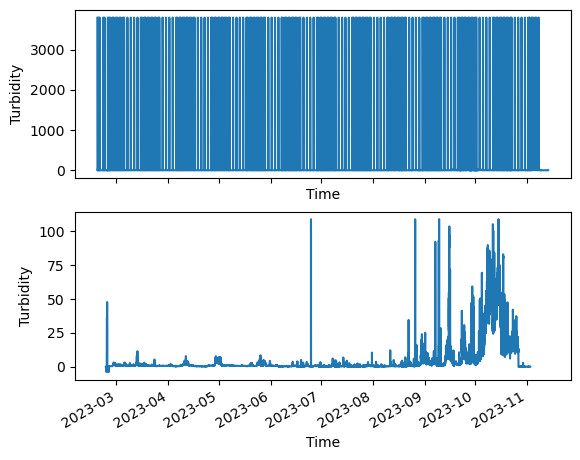

In [10]:
# Plot unfiltered turbidity timeseries from Seapoint sensors on NSIF and MFN
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
tuNSIF.plot.line(ax=axs[0])
tuMFN.plot.line(ax=axs[1])

The turbidity from the NSIF Seapoint Turbidity sensor has data values greater than the expected range of the sensor, so we will apply a simple mask for values greater than 25 NTU (expected 0-25 NTU) to resolve the majority of the measured values in the time series. The expected range for the sensor on the NSIF referenced here is pulled from the At-Sea Test 3 Plan document. The Seapoint Turbidity sensor data sheet indicates that the maximum FTU (used in data sheet) value is only 4000 when gain is set to 1x. Gain should have been set to 100x for maximum readings of 25 FTU. The Deployment Info screenshot on the raw data repo shows that the sensor range was set to 25 NTU.

In [6]:
# Mask turbidity values from NSIF Seapoint over 25 NTU
tuNSIF25 = tuNSIF.where(tuNSIF <= 25)

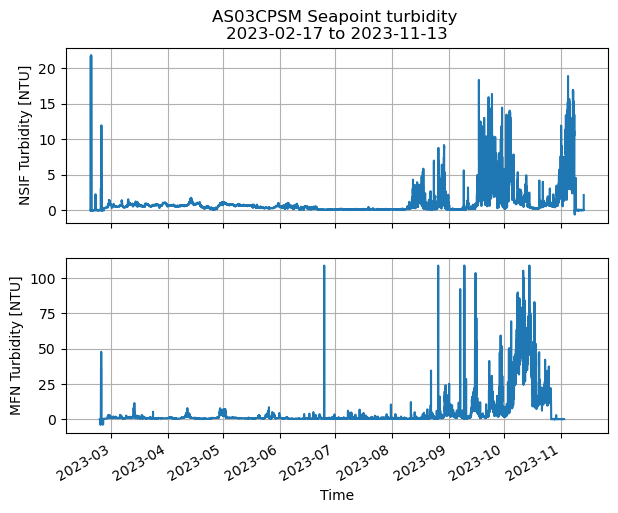

In [26]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFN.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{tuNSIF25["Time"][0].values:.10} to {tuNSIF25["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Plot Seapoint turbidity in July with smaller turbidity range

In [32]:
# Select Seapoint turbidity measured in July 2023
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023")
tuMFN_Jul = tuMFN.sel(Time="July 2023")

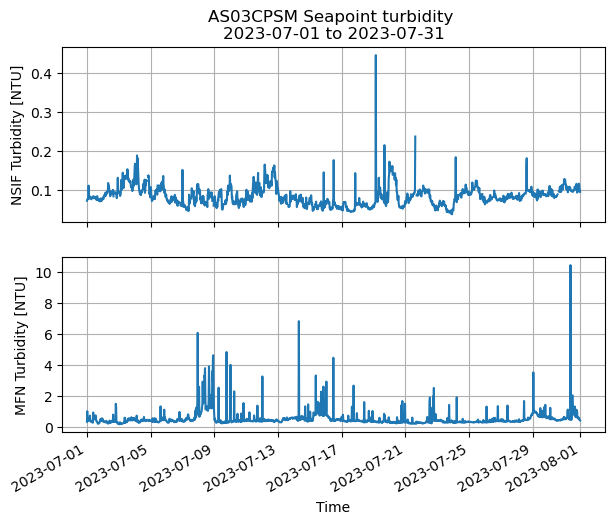

In [33]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFN_Jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Apply a median smoothing filter to Seapoint turbidity

In [34]:
# Use rolling window object for a 6-hour median smoothing filter
tuNSIFmedian_Jul = tuNSIF25_Jul.rolling(Time=12, center=True).median()
tuMFNmedian_Jul = tuMFN_Jul.rolling(Time=12, center=True).median()

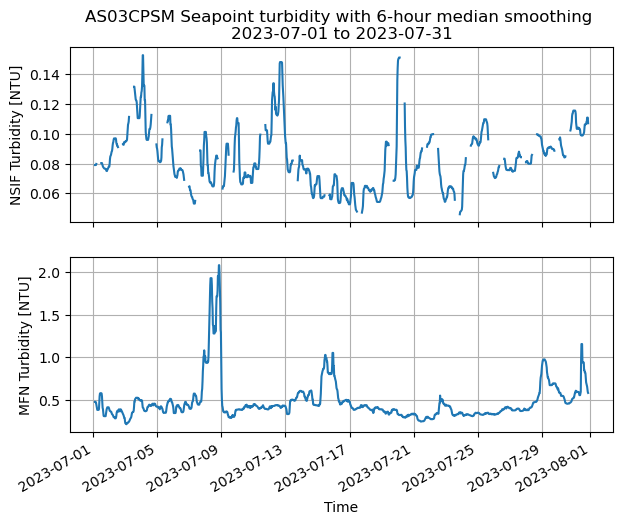

In [36]:
# Plot median-smoothed NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIFmedian_Jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFNmedian_Jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity with 6-hour median smoothing \n{tuNSIFmedian_Jul["Time"][0].values:.10} to {tuNSIFmedian_Jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_6hrmedian_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

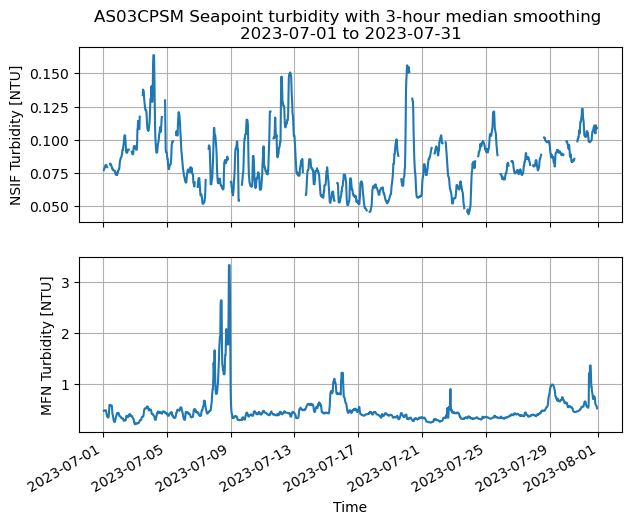

In [37]:
# Try filtering with a 3 hour median filter for better coverage
tuNSIFmedian_Jul = tuNSIF25_Jul.rolling(Time=6, center=True).median()
tuMFNmedian_Jul = tuMFN_Jul.rolling(Time=6, center=True).median()

# Plot median-smoothed NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIFmedian_Jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFNmedian_Jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity with 3-hour median smoothing \n{tuNSIFmedian_Jul["Time"][0].values:.10} to {tuNSIFmedian_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_3hrmedian_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Compare recovered instrument turbidity with FLORT and shipboard transmissometers

#### Download flort1 recovered host data

In [36]:
# need to donwload FLORT recovered host files for dates only during AST3 deployment
# following a couple tutorials to figure out how to do this in parallel
def is_valid(url):
    """ Checks whether URL is valid
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def get_file_urls(url: str, instr: str, start_date: int, end_date: int):
    """ Returns URLS to any .log files on the page.
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for log in tqdm(soup.find_all("a", string=re.compile(instr+".log\Z")), "Finding logger files"):
        log_url = log.attrs.get("href")
        if int(log_url[:8]) >= start_date and int(log_url[:8]) <= end_date:
            log_url = urljoin(url, log_url)
            if is_valid(log_url):
                urls.append(log_url)
        else:
            continue

    return urls

In [6]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/"

In [16]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="flort1", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 308/308 [00:00<00:00, 25572.49it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230224.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230225.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230226.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230227.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230228.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230301.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230302.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230303.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230304.flort1.log',
 

In [17]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230227.flort1.log
Downloaded file 20230319.flort1.log
Downloaded file 20230314.flort1.log
Downloaded file 20230304.flort1.log
Downloaded file 20230309.flort1.log
Downloaded file 20230226.flort1.log
Downloaded file 20230305.flort1.log
Downloaded file 20230303.flort1.log
Downloaded file 20230318.flort1.log
Downloaded file 20230228.flort1.log
Downloaded file 20230308.flort1.log
Downloaded file 20230313.flort1.log
Downloaded file 20230310.flort1.log
Downloaded file 20230315.flort1.log
Downloaded file 20230320.flort1.log
Downloaded file 20230321.flort1.log
Downloaded file 20230323.flort1.log
Downloaded file 20230322.flort1.log
Downloaded file 20230324.flort1.log
Downloaded file 20230224.flort1.log
Downloaded file 20230312.flort1.log
Downloaded file 20230325.flort1.log
Downloaded file 20230327.flort1.log
Downloaded file 20230306.flort1.log
Downloaded file 20230301.flort1.log
Downloaded file 20230328.flort1.log
Downloaded file 20230311.flort1.log
Downloaded file 20230326.flo

#### Load flort1 data from logger files 

In [2]:
# Use FLORT class imported from Parsers.parsers to load flort1 data from downloaded logger files
files = glob.glob("C:/Users/kylene.cooley/ast3_turbidity_data/*.flort1.log")
flort = FLORT()
flort.load_flort(files)
flor_data = flort.DATA

Parsing ast3_turbidity_data\20230222.flort1.log
Parsing ast3_turbidity_data\20230223.flort1.log
Parsing ast3_turbidity_data\20230224.flort1.log
Parsing ast3_turbidity_data\20230225.flort1.log
Parsing ast3_turbidity_data\20230226.flort1.log
Parsing ast3_turbidity_data\20230227.flort1.log
Parsing ast3_turbidity_data\20230228.flort1.log
Parsing ast3_turbidity_data\20230301.flort1.log
Parsing ast3_turbidity_data\20230302.flort1.log
Parsing ast3_turbidity_data\20230303.flort1.log
Parsing ast3_turbidity_data\20230304.flort1.log
Parsing ast3_turbidity_data\20230305.flort1.log
Parsing ast3_turbidity_data\20230306.flort1.log
Parsing ast3_turbidity_data\20230307.flort1.log
Parsing ast3_turbidity_data\20230308.flort1.log
Parsing ast3_turbidity_data\20230309.flort1.log
Parsing ast3_turbidity_data\20230310.flort1.log
Parsing ast3_turbidity_data\20230311.flort1.log
Parsing ast3_turbidity_data\20230312.flort1.log
Parsing ast3_turbidity_data\20230313.flort1.log
Parsing ast3_turbidity_data\20230314.flo

c:\Users\kylene.cooley\Documents\GitHub\AST3\Parsers\parsers.py:571: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.DATA = flort_data.astype(self.DATA_TYPE)


In [3]:
flor_data

,LGR_TIMESTAMP,TIMESTAMP,CH1,700NM_COUNTS,CH2,695NM_COUNTS,CH3,460NM_COUNTS,THERM_COUNTS
0,2023-02-22 00:00:15.429,2023-02-21 23:59:36,700,4130,695,1253,460,4130,543
1,2023-02-22 00:00:16.563,2023-02-21 23:59:37,700,4130,695,1253,460,4130,543
2,2023-02-22 00:00:17.697,2023-02-21 23:59:38,700,4130,695,1251,460,4130,543
3,2023-02-22 00:00:18.831,2023-02-21 23:59:39,700,4130,695,1254,460,4130,542
4,2023-02-22 00:00:19.964,2023-02-21 23:59:41,700,4130,695,1251,460,4130,543
...,...,...,...,...,...,...,...,...,...
804,2023-10-26 09:00:56.910,2023-10-26 08:56:35,700,519,695,158,460,59,542
805,2023-10-26 09:00:58.025,2023-10-26 08:56:36,700,361,695,150,460,61,542
806,2023-10-26 09:00:59.154,2023-10-26 08:56:37,700,392,695,140,460,61,542
807,2023-10-26 09:01:00.284,2023-10-26 08:56:39,700,619,695,136,460,60,542


In [4]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1005
tu_flort = flort.flort2turb(scale_factor=0.0008, dark_counts=49)

In [5]:
tu_flort

,LGR_TIMESTAMP,TIMESTAMP,CH1,700NM_COUNTS,CH2,695NM_COUNTS,CH3,460NM_COUNTS,THERM_COUNTS,backscatter_turb
0,2023-02-22 00:00:15.429,2023-02-21 23:59:36,700,4130,695,1253,460,4130,543,3.2648
1,2023-02-22 00:00:16.563,2023-02-21 23:59:37,700,4130,695,1253,460,4130,543,3.2648
2,2023-02-22 00:00:17.697,2023-02-21 23:59:38,700,4130,695,1251,460,4130,543,3.2648
3,2023-02-22 00:00:18.831,2023-02-21 23:59:39,700,4130,695,1254,460,4130,542,3.2648
4,2023-02-22 00:00:19.964,2023-02-21 23:59:41,700,4130,695,1251,460,4130,543,3.2648
...,...,...,...,...,...,...,...,...,...,...
804,2023-10-26 09:00:56.910,2023-10-26 08:56:35,700,519,695,158,460,59,542,0.3760
805,2023-10-26 09:00:58.025,2023-10-26 08:56:36,700,361,695,150,460,61,542,0.2496
806,2023-10-26 09:00:59.154,2023-10-26 08:56:37,700,392,695,140,460,61,542,0.2744
807,2023-10-26 09:01:00.284,2023-10-26 08:56:39,700,619,695,136,460,60,542,0.4560


In [11]:
tu_flort = tu_flort.rename({"TIMESTAMP": "time"}, axis=1)
tu_flort

,LGR_TIMESTAMP,time,CH1,700NM_COUNTS,CH2,695NM_COUNTS,CH3,460NM_COUNTS,THERM_COUNTS,backscatter_turb
0,2023-02-22 00:00:15.429,2023-02-21 23:59:36,700,4130,695,1253,460,4130,543,3.2648
1,2023-02-22 00:00:16.563,2023-02-21 23:59:37,700,4130,695,1253,460,4130,543,3.2648
2,2023-02-22 00:00:17.697,2023-02-21 23:59:38,700,4130,695,1251,460,4130,543,3.2648
3,2023-02-22 00:00:18.831,2023-02-21 23:59:39,700,4130,695,1254,460,4130,542,3.2648
4,2023-02-22 00:00:19.964,2023-02-21 23:59:41,700,4130,695,1251,460,4130,543,3.2648
...,...,...,...,...,...,...,...,...,...,...
804,2023-10-26 09:00:56.910,2023-10-26 08:56:35,700,519,695,158,460,59,542,0.3760
805,2023-10-26 09:00:58.025,2023-10-26 08:56:36,700,361,695,150,460,61,542,0.2496
806,2023-10-26 09:00:59.154,2023-10-26 08:56:37,700,392,695,140,460,61,542,0.2744
807,2023-10-26 09:01:00.284,2023-10-26 08:56:39,700,619,695,136,460,60,542,0.4560


In [12]:
# Convert Data Frame to Xarray Dataset
flort_ntu = xr.Dataset.from_dataframe(tu_flort.set_index("time"))
flort_ntu

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

In [15]:
# Save Dataset to netCDF
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
flort_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl16_flort1.nc"]), mode="w")

#### Compare turbidity from flort1 and Seapoint turbidity on NSIF 

In [19]:
flort1_ntu = xr.load_dataset("C:/Users/kylene.cooley/ast3_turbidity_data/as03cpsm_dcl16_flort1.nc")
flort1_ntu

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

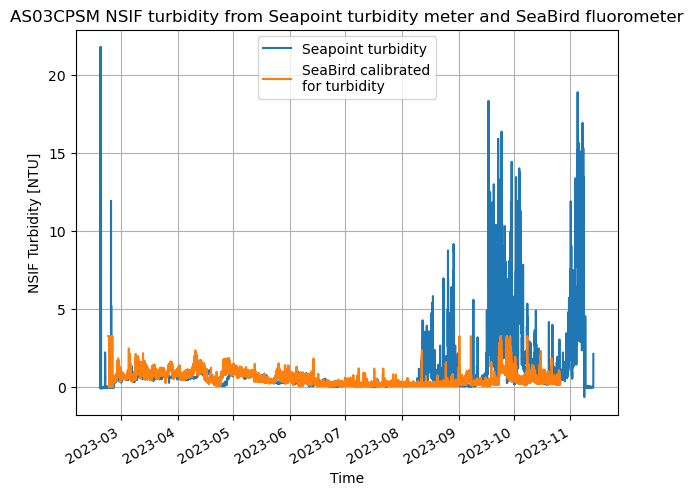

In [8]:
# Plot masked NSIF Seapoint turbidity (not smoothed) with turbidity from flort1 backscatter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25.plot.line(ax=axs, label="Seapoint turbidity")
flort1_ntu["backscatter_turb"].plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_turbidity_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [14]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023")
flort1_ntu_Jul = flort1_ntu["backscatter_turb"].sel(time="July 2023")

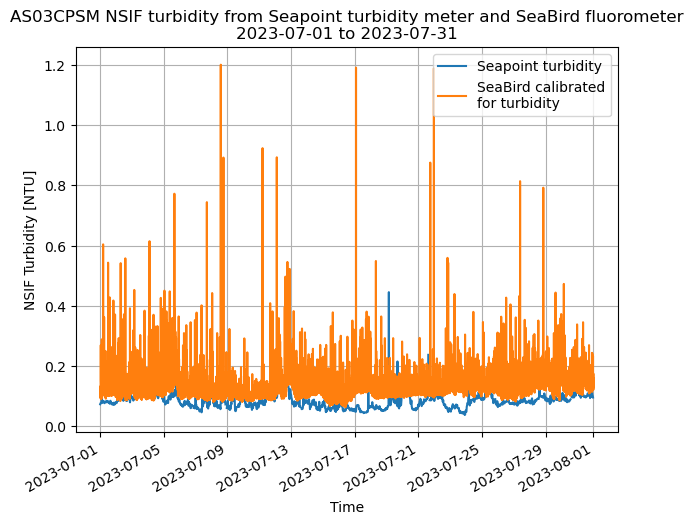

In [10]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs, label="Seapoint turbidity")
flort1_ntu_Jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [21]:
# Remake July 2023 plot after applying median smoothing to both timeseries
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023").rolling(Time=6, center=True).median()
flort1_ntu_Jul = flort1_ntu["backscatter_turb"].sel(time="July 2023").rolling(time=6*1800, center=True).median() 
# I thought flort samples were recorded every second continuously but this may not be the case,
# so at 1800 samples every 30 min, I thought 6*1800 would have been 3 hours of data points

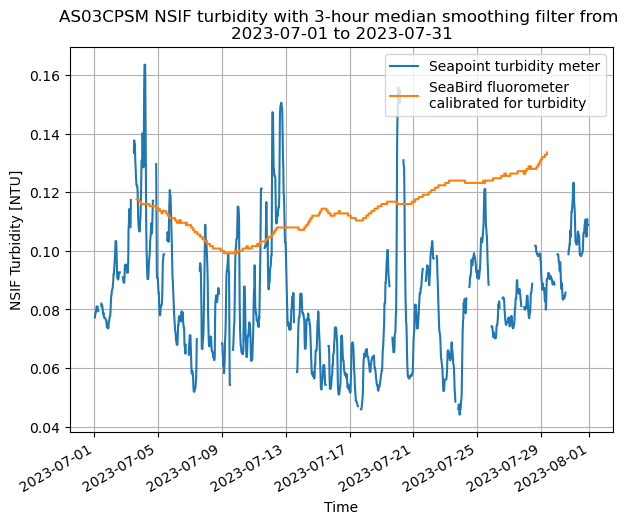

In [22]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_ntu_Jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 3-hour median smoothing filter from \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [30]:
# Trying a median filter for flort of 360 samples, so see where this gets us, and same 3-hr median for turbidity meter
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023").rolling(Time=6, center=True).median()
flort1_ntu_Jul = flort1_ntu["backscatter_turb"].sel(time="July 2023").rolling(time=360, center=True).median()

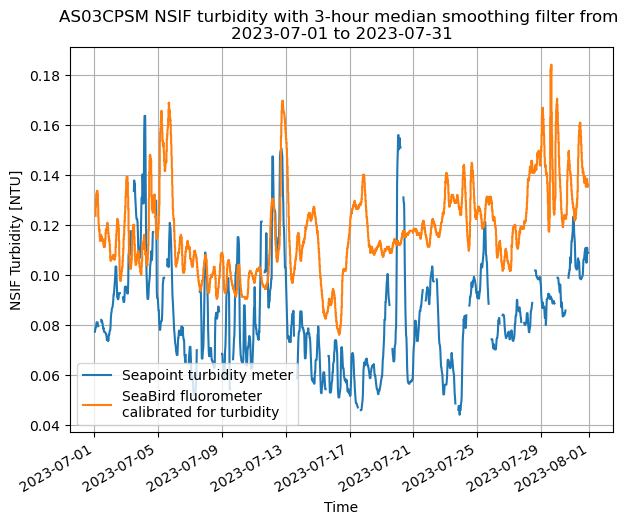

In [31]:
# Plot 3-hour median filtered NSIF Seapoint turbidity and SeaBird turbidity from flort
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_ntu_Jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 3-hour median smoothing filter from \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [32]:
# Now we've worked out that 60 flort samples to 1 turbd sample works well
# Let's apply a 12-hour median filter, with goal of resolving daily trends 
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023").rolling(Time=6*4, center=True).median()
flort1_ntu_Jul = flort1_ntu["backscatter_turb"].sel(time="July 2023").rolling(time=360*4, center=True).median()

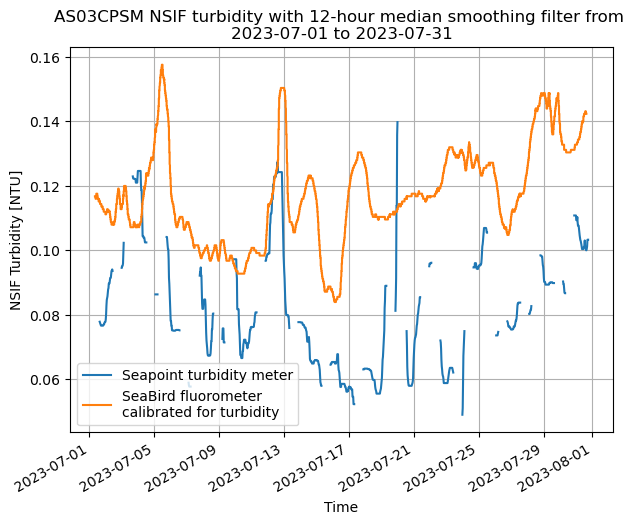

In [33]:
# Plot 12-hour median filtered NSIF Seapoint turbidity and SeaBird turbidity from flort
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_ntu_Jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 12-hour median smoothing filter from \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [34]:
# 12 hours seems like it was too much smoothing for Seapoint turbidity
# Let's do a goldilocks and try 6-hr smoothing
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023").rolling(Time=6*2, center=True).median()
flort1_ntu_Jul = flort1_ntu["backscatter_turb"].sel(time="July 2023").rolling(time=360*2, center=True).median()

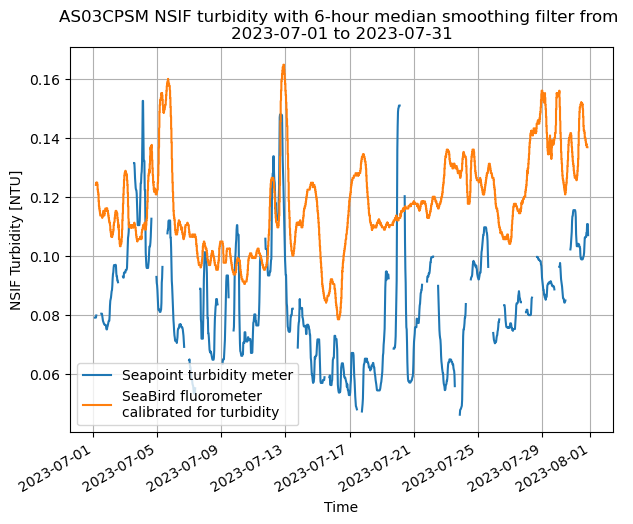

In [35]:
# Plot 6-hour median filtered NSIF Seapoint turbidity and SeaBird turbidity from flort
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_ntu_Jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter from \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Download and parse flort2 recovered host files

In [37]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/"

In [38]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="flort2", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 305/305 [00:00<00:00, 63876.90it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230224.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230225.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230226.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230227.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230228.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230301.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230302.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230303.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230304.flort2.log',
 

In [41]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230303.flort2.logDownloaded file 20230301.flort2.log

Downloaded file 20230226.flort2.log
Downloaded file 20230309.flort2.log
Downloaded file 20230307.flort2.log
Downloaded file 20230302.flort2.log
Downloaded file 20230306.flort2.log
Downloaded file 20230227.flort2.log
Downloaded file 20230313.flort2.log
Downloaded file 20230228.flort2.log
Downloaded file 20230320.flort2.log
Downloaded file 20230321.flort2.log
Downloaded file 20230324.flort2.log
Downloaded file 20230322.flort2.log
Downloaded file 20230323.flort2.log
Downloaded file 20230325.flort2.log
Downloaded file 20230326.flort2.log
Downloaded file 20230327.flort2.log
Downloaded file 20230328.flort2.log
Downloaded file 20230329.flort2.log
Downloaded file 20230318.flort2.log
Downloaded file 20230319.flort2.log
Downloaded file 20230224.flort2.log
Downloaded file 20230314.flort2.log
Downloaded file 20230311.flort2.log
Downloaded file 20230330.flort2.logDownloaded file 20230402.flort2.log

Downloaded file 20230310.flo

In [ ]:
# Use FLORT class imported from Parsers.parsers to load flort2 data from downloaded logger files
files = glob.glob("C:/Users/kylene.cooley/ast3_turbidity_data/*.flort2.log")
flort2 = FLORT()
flort2.load_flort(files)
flor_data = flort2.DATA
flor_data

In [44]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1003
tu_flort2 = flort2.flort2turb(scale_factor=0.0300, dark_counts=50)
tu_flort2 = tu_flort2.rename({"TIMESTAMP": "time"}, axis=1)

In [45]:
# Convert Data Frame to Xarray Dataset
flort2_ntu = xr.Dataset.from_dataframe(tu_flort2.set_index("time"))
flort2_ntu

<xarray.Dataset>
Dimensions:           (time: 244578)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-24T00:00:15.005000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 250 250 250 249
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1174 1172 1172 1171 1171 ... 48 46 46 46 46
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 2128 2130 2133 2136 2134 ... 41 39 42 44 42
    THERM_COUNTS      (time) int32 549 549 549 549 549 ... 542 542 542 542 542
    backscatter_turb  (time) float64 122.4 122.4 122.4 122.4 ... 6.0 6.0 5.97

In [47]:
# Save Dataset to netCDF
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
flort2_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl36_flort2.nc"]), mode="w")

#### Compare turbidity from SeaBird flort2 and Seapoint turbd on MFN

In [48]:
# Check MFN turbd time delta
tuMFN

<xarray.DataArray 'Turbidity' (Time: 12147)>
array([0.04279942, 0.04303848, 0.04327754, ..., 0.04351661, 0.04351661,
       0.06646668])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-22T17:00:01 ... 2023-11-02T18:00:01

In [52]:
# Checking flort2 time delta while reassinging just the turbidity data array to name flort2_ntu
flort2_ntu = flort2_ntu["backscatter_turb"]
flort2_ntu

<xarray.DataArray 'backscatter_turb' (time: 244578)>
array([122.4 , 122.4 , 122.4 , ...,   6.  ,   6.  ,   5.97])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-26T22:58:13

The turbidity sensor on the MFN was not connected to the same dcl as the flort, so it is also recording a sample every 30 mins like the turbd on the NSIF.
The flort on the MFN only sampled at 1 Hz for 1 minute at the start of every hour.
I will be selecting just the turbidity meter sample from the first half of the hour.

In [60]:
# Index tubidity meter samples from the MFN taken at the top of the hour
turbd_mfn = tuMFN.sel(Time=(tuMFN.Time.dt.minute==00), method="nearest")
turbd_mfn

<xarray.DataArray 'Turbidity' (Time: 6074)>
array([0.04279942, 0.04327754, 0.04279942, ..., 0.04303848, 0.04351661,
       0.06646668])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-22T17:00:01 ... 2023-11-02T18:00:01

In [61]:
# Apply 6-hr median filter to both flort turbd and turbidity meter time series
turbd_mfn_med = turbd_mfn.rolling(Time=6, center=True).median()
flort2_ntu_med = flort2_ntu.rolling(time=360, center=True).median()

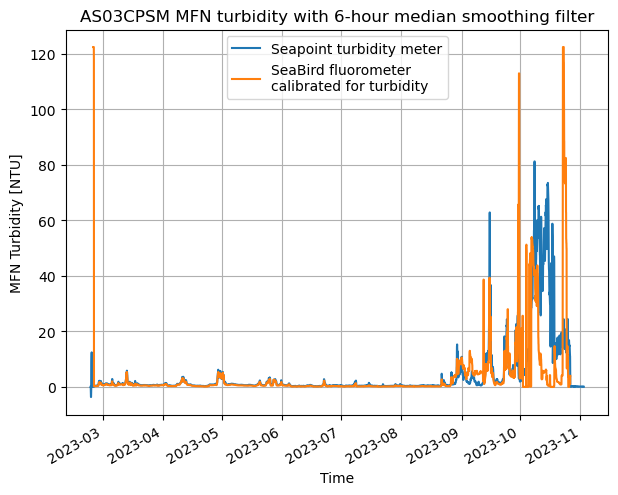

In [62]:
# Plot 6-hour median filtered NSIF Seapoint turbidity and SeaBird turbidity from flort
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd_mfn_med.plot.line(ax=axs, label="Seapoint turbidity meter")
flort2_ntu_med.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity with 6-hour median smoothing filter')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

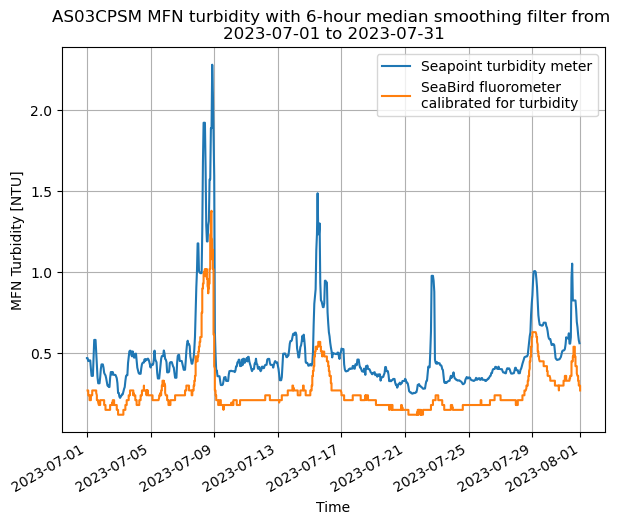

In [81]:
# Plot 6-hour median filtered NSIF Seapoint turbidity and SeaBird turbidity from flort
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd_mfn_med.sel(Time="July 2023").plot.line(ax=axs, label="Seapoint turbidity meter")
flort2_ntu_med.sel(time="July 2023").plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity with 6-hour median smoothing filter from \n{turbd_mfn_med.sel(Time="July 2023")["Time"][0].values:.10} to {turbd_mfn_med.sel(Time="July 2023")["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

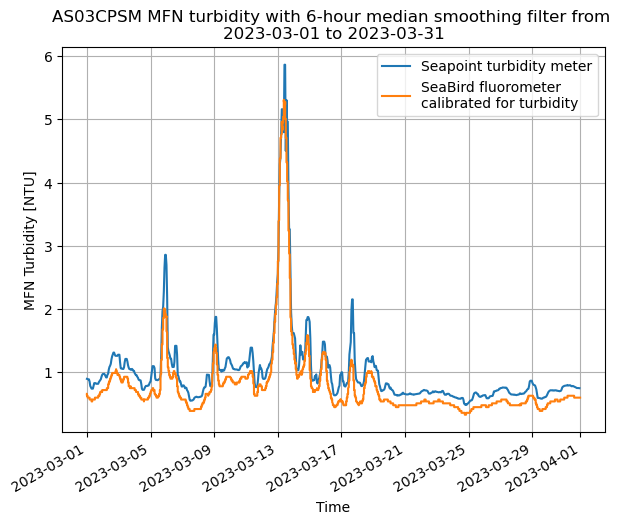

In [82]:
# Plot earlier in deployment - Mar 2023
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd_mfn_med.sel(Time="March 2023").plot.line(ax=axs, label="Seapoint turbidity meter")
flort2_ntu_med.sel(time="March 2023").plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity with 6-hour median smoothing filter from \n{turbd_mfn_med.sel(Time="March 2023")["Time"][0].values:.10} to {turbd_mfn_med.sel(Time="March 2023")["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Check difference between MFN turbidity signals for constant offset

In [ ]:
# Use larger smoothing window on both datasets


In [69]:
# Evaluate difference between Seapoint turbidity and SeaBird turbidity from flort2
turbd_mfn_diff = turbd_mfn_med - flort2_ntu_med[np.linspace(0, 244577, num=6074, dtype=int)].values
turbd_mfn_diff

<xarray.DataArray 'Turbidity' (Time: 6074)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-22T17:00:01 ... 2023-11-02T18:00:01

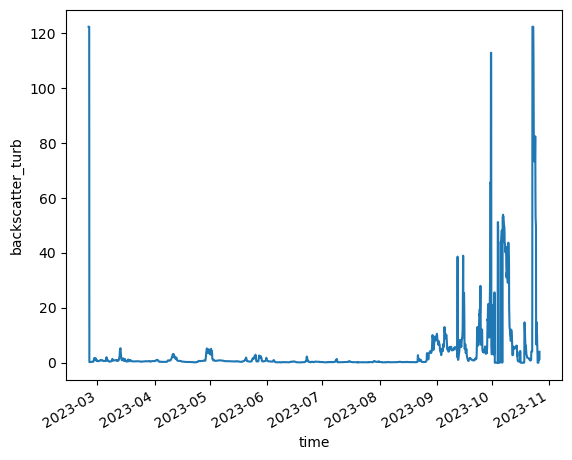

In [71]:
flort2_ntu_med[np.linspace(0, 244577, num=6074, dtype=int)].plot()

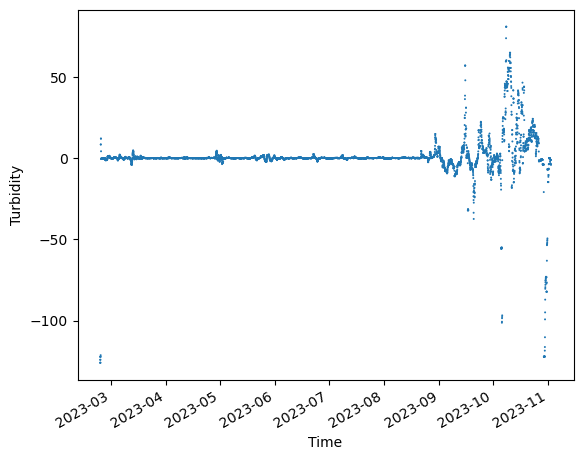

In [79]:
turbd_mfn_diff.plot.scatter(edgecolor="none", s=2)

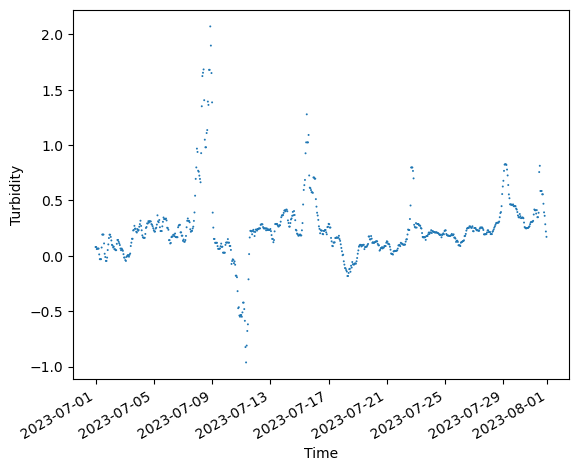

In [80]:
turbd_mfn_diff.sel(Time="July 2023").plot.scatter(edgecolor="none", s=2)
